In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')
path = '/content/gdrive/My Drive/PCA_SVM/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_random_seed(123456)

Using TensorFlow backend.


In [0]:
df = pd.read_csv(path + 'creditcard.csv')

In [0]:
df.shape

(284807, 31)

In [0]:
data, data_test = train_test_split(df, test_size=0.25)


### Dataset Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [0]:
# reset_index = True resets the index to the default integer index (i.e. 0, 1, 2, ..., m)
raw_data_sample = data[data['Class'] == 0].sample(1000).append(data[data['Class'] == 1]).sample(frac=1).reset_index(drop=True)

raw_data_sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,130030.0,-0.237432,0.841994,-0.873499,-0.987010,1.686711,1.196473,0.485981,0.595062,0.157745,-0.439106,0.862478,-0.205000,-1.594901,-0.530732,0.058503,-0.115990,0.805962,-0.693983,-0.800050,-0.025578,-0.299184,-0.646481,0.116880,-1.093683,-0.588950,0.234334,0.370088,0.112346,5.37,0
1,8451.0,0.314597,2.660670,-5.920037,4.522500,-2.315027,-2.278352,-4.684054,1.202270,-0.694696,-5.526278,6.662437,-8.525465,0.742745,-7.678668,0.593070,-4.478137,-5.844266,-1.102731,2.177386,0.562706,0.743314,0.064038,0.677842,0.083008,-1.911034,0.322188,0.620867,0.185030,1.00,1
2,60480.0,1.175940,-0.159485,-1.213320,0.301701,2.141847,3.623126,-0.379087,0.837418,0.167131,-0.039339,-0.541686,0.237992,-0.214755,0.201722,-0.145469,-0.095333,-0.509491,-0.067061,0.349125,0.053328,-0.156026,-0.504686,-0.166470,1.012198,0.876597,-0.331453,0.016793,0.020333,53.63,0
3,115691.0,-1.550273,1.088689,-2.393388,1.008733,-1.087562,-1.104602,-2.670503,0.147655,-0.978626,-3.514133,3.586042,-4.053358,0.862426,-5.765823,-0.507511,-4.921865,-9.567268,-2.772974,1.717095,0.327490,0.802316,1.037105,0.095815,-0.320191,-0.080731,0.091012,0.024928,-0.077820,17.06,1
4,121906.0,2.193770,-1.594469,-0.316619,-1.429214,-1.773657,-0.497934,-1.533021,-0.085693,-0.878787,1.521359,-0.747380,-0.592949,0.750439,-0.764173,0.098069,-0.371368,0.441160,0.297431,-0.566960,-0.340137,0.138634,0.892122,0.201487,1.168394,-0.236176,-0.022404,0.036604,-0.025818,42.00,0


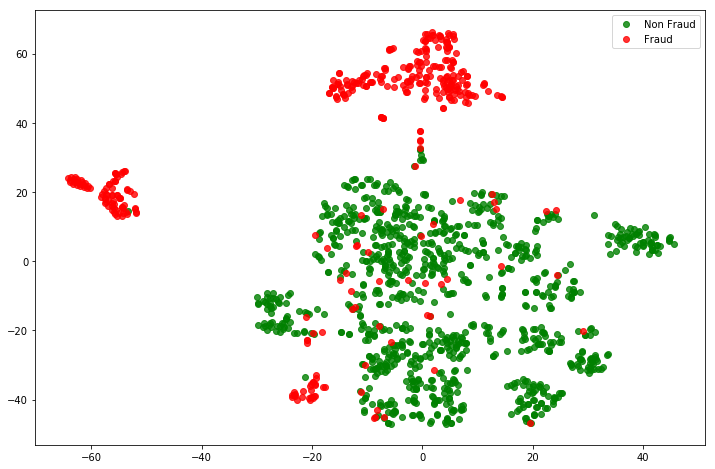

In [0]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
raw_data_x = raw_data_sample.drop(['Class'], axis = 1)
raw_data_x[['Time']]=MinMaxScaler().fit_transform(raw_data_x[['Time']])
raw_data_x[['Amount']]=MinMaxScaler().fit_transform(raw_data_x[['Amount']])
tsne_plot(raw_data_x, raw_data_sample["Class"].values, "raw.png")

Now as an alternative, we transform the Time field to time-of-day to account for intraday seasonality, with the intuition that transactions that happen at certain time-of-day such as late night could be fraudulent. The Amount field is transformed to log scale for normalization, with the intuition that the scale of magnitute of a transaction could be a more relevant feature for fraud than linear amounts.



In [0]:
data.loc[:,"Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.loc[:,'Amount'] = np.log(data['Amount']+1)

data_test.loc[:,"Time"] = data_test["Time"].apply(lambda x : x / 3600 % 24)
data_test.loc[:,'Amount'] = np.log(data_test['Amount']+1)
# data = data.drop(['Amount'], axis = 1)
print(data.shape)
data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(213605, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
194763,12.318611,2.047163,0.107987,-1.806515,0.072733,0.248371,-1.744837,0.712448,-0.488842,-0.102709,0.181618,1.631225,1.176142,-0.241013,1.040992,-0.328446,-0.673208,-0.245852,-0.331582,0.113072,-0.261380,0.241017,0.822618,0.023000,0.549868,0.322173,0.191755,-0.085025,-0.084292,0.570980,0
135660,22.595556,1.282404,0.459864,-0.372286,0.826375,0.463568,-0.466407,0.460867,-0.186469,-0.549700,0.203961,0.787663,0.882770,0.417271,0.642625,-0.010424,0.161875,-0.835298,0.302139,0.293010,-0.096751,0.013986,0.083896,-0.247504,-0.325527,0.927293,-0.272555,-0.010168,-0.005332,1.026042,0
259186,20.167778,-0.414863,0.012026,1.356386,1.107374,0.813456,-0.156497,-0.372675,0.031095,-0.100143,-0.158606,-1.137380,0.674799,2.027621,-0.272567,1.802644,-0.812031,0.098509,0.376851,2.958766,0.564341,-0.052272,-0.088160,0.062521,-0.680805,-0.641474,-0.159995,0.237628,0.204343,1.938742,0
87387,17.128333,-1.432948,1.478076,0.576724,0.207540,-0.670662,-0.464572,0.221023,-0.099811,1.561896,1.511193,-0.029435,0.710931,0.088355,-0.913471,-0.376058,-0.992295,0.361036,-1.219535,-0.514430,0.266179,-0.055014,0.364330,0.154670,0.635611,-0.366314,0.163690,-0.750285,-0.275117,2.322388,0
267282,21.195278,2.051016,-0.016765,-2.284865,0.302168,0.786895,-0.998558,0.768990,-0.464383,0.362863,-0.031401,-1.124247,0.263750,-0.036857,0.617273,-0.146163,-0.774674,-0.240874,-0.438419,0.273518,-0.139341,0.133331,0.491780,-0.119020,0.527179,0.607105,-0.090453,-0.065787,-0.062680,3.882182,0


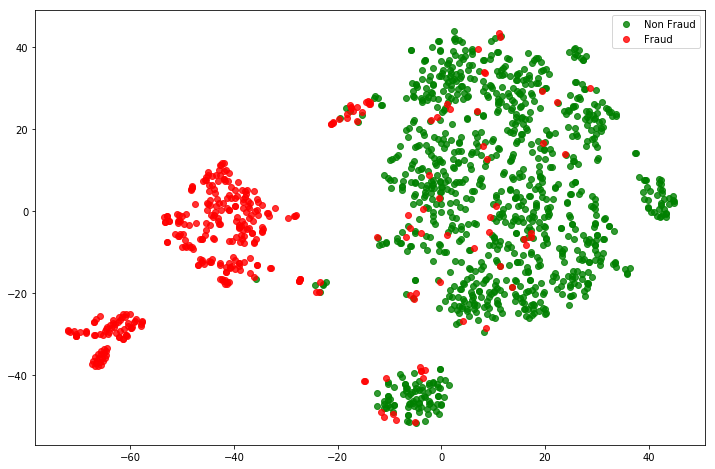

In [0]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

tsne_plot(X, Y, "original.png")

In [0]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='sigmoid')(encoded) 

## decoding part
decoded = Dense(50, activation='tanh')(encoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded) 

# Autoencoder model
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer="adadelta", loss="mse")

# Min-max scaling 
x = data.drop(["Class"], axis=1)
y = data["Class"].values

# x_scale = MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

checkpointer = ModelCheckpoint(filepath='bestmodel.hdf5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)
x_norm_train_sample = x_norm[np.random.randint(x_norm.shape[0], size=10000),:]

hist = autoencoder.fit(x_norm_train_sample, x_norm_train_sample, 
                batch_size = 256, epochs = 400, 
                shuffle = True, validation_split = 0.05, verbose=1, callbacks=[checkpointer, earlystopper])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 9500 samples, validate on 500 samples
Epoch 1/400
9500/9500 [==============================] - 1s 141us/step - loss: 7.0300 - val_loss: 4.7068
Epoch 2/400
9500/9500 [==============================] - 0s 15us/step - loss: 3.6452 - val_loss: 2.9773
Epoch 3/400
9500/9500 [==============================] - 0s 15us/step - loss: 2.5120 - val_loss: 2.2599
Epoch 4/400
9500/9500 [==============================] - 0s 15us/step - loss: 2.0578 - val_loss: 2.1618
Epoch 5/400
9500/9500 [==============================] - 0s 15us/step - loss: 1.9092 - val_loss: 2.1545
Epoch 6/400
9500/9500 [==============================] - 0s 15us/step - loss: 1.8256 - val_loss: 1.6914
Epoch 7/400
9500/9500 [==============================] - 0s 15us/step - loss: 1.7479 - val_loss: 1.5167
Epoch 8/400
9500/9500 [==============================] - 0s 14us/step - loss: 1.6739 - val_loss: 1.4939


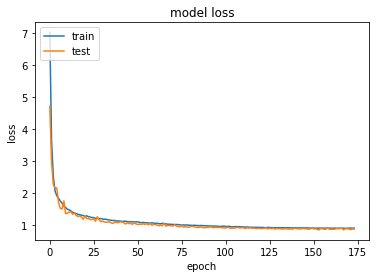

In [0]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_loss(hist)

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1530      
Total params: 12,230
Trainable params: 12,230
Non-trainable params: 0
_________________________________________________________________


Extract latent representation by running transactions through the trained encoding layers of the autoencoder. We do so for another sample of 700 non-fraud transactions plus all fraud transactions from the training set. 700 is chosen to be consistent with the original paper.

In [0]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

norm_hid_rep = hidden_representation.predict(x_norm[np.random.randint(x_norm.shape[0], size=700),:])
fraud_hid_rep = hidden_representation.predict(x_fraud)


In [0]:
norm_hid_rep.shape, fraud_hid_rep.shape

((700, 50), (372, 50))

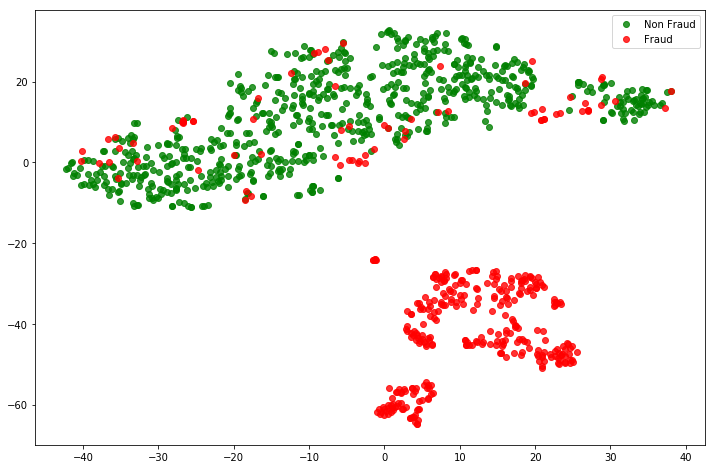

In [0]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, path + "latent_representation.png")

In [0]:
def xavier_init(size): # initialize the weight-matrix W.
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

  ## OCAN TF Training Utils
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_logit = tf.nn.tanh(tf.matmul(G_h1, G_W2) + G_b2)
    return G_logit

  
def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.softmax(D_logit)
    return D_prob, D_logit, D_h2


# pre-train net for density estimation.
def discriminator_tar(x):
    T_h1 = tf.nn.relu(tf.matmul(x, T_W1) + T_b1)
    T_h2 = tf.nn.relu(tf.matmul(T_h1, T_W2) + T_b2)
    T_logit = tf.matmul(T_h2, T_W3) + T_b3
    T_prob = tf.nn.softmax(T_logit)
    return T_prob, T_logit, T_h2
  
def pull_away_loss(g):

    Nor = tf.norm(g, axis=1)
    Nor_mat = tf.tile(tf.expand_dims(Nor, axis=1),
                      [1, tf.shape(g)[1]])
    X = tf.divide(g, Nor_mat)
    X_X = tf.square(tf.matmul(X, tf.transpose(X)))
    mask = tf.subtract(tf.ones_like(X_X),
                       tf.diag(
                           tf.ones([tf.shape(X_X)[0]]))
                       )
    pt_loss = tf.divide(tf.reduce_sum(tf.multiply(X_X, mask)),
                        tf.multiply(
                            tf.cast(tf.shape(X_X)[0], tf.float32),
                            tf.cast(tf.shape(X_X)[0]-1, tf.float32)))

    return pt_loss
  
def sample_shuffle_uspv(X):
    n_samples = len(X)
    s = np.arange(n_samples)
    np.random.shuffle(s)
    return np.array(X[s])
  
def one_hot(x, depth):
    x_one_hot = np.zeros((len(x), depth), dtype=np.int32)
    x = x.astype(int)
    for i in range(x_one_hot.shape[0]):
        x_one_hot[i, x[i]] = 1
    return x_one_hot


def sample_Z(m, n):   # generating the input for G.
    return np.random.uniform(-1., 1., size=[m, n])
  
  
dim_input = norm_hid_rep.shape[1]
mb_size = 70

D_dim = [dim_input, 100, 50, 2]
G_dim = [50, 100, dim_input]
Z_dim = G_dim[0]

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])

# define placeholders for labeled-data, unlabeled-data, noise-data and target-data.

X_oc = tf.placeholder(tf.float32, shape=[None, dim_input])
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])
X_tar = tf.placeholder(tf.float32, shape=[None, dim_input])
# X_val = tf.placeholder(tf.float32, shape=[None, dim_input])


# declare weights and biases of discriminator.

D_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
D_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

D_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
D_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

D_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
D_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]



# declare weights and biases of generator.

G_W1 = tf.Variable(xavier_init([G_dim[0], G_dim[1]]))
G_b1 = tf.Variable(tf.zeros(shape=[G_dim[1]]))

G_W2 = tf.Variable(xavier_init([G_dim[1], G_dim[2]]))
G_b2 = tf.Variable(tf.zeros(shape=[G_dim[2]]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


# declare weights and biases of pre-train net for density estimation.

T_W1 = tf.Variable(xavier_init([D_dim[0], D_dim[1]]))
T_b1 = tf.Variable(tf.zeros(shape=[D_dim[1]]))

T_W2 = tf.Variable(xavier_init([D_dim[1], D_dim[2]]))
T_b2 = tf.Variable(tf.zeros(shape=[D_dim[2]]))

T_W3 = tf.Variable(xavier_init([D_dim[2], D_dim[3]]))
T_b3 = tf.Variable(tf.zeros(shape=[D_dim[3]]))

theta_T = [T_W1, T_W2, T_W3, T_b1, T_b2, T_b3]

D_prob_real, D_logit_real, D_h2_real = discriminator(X_oc)

G_sample = generator(Z)
D_prob_gen, D_logit_gen, D_h2_gen = discriminator(G_sample)

D_prob_tar, D_logit_tar, D_h2_tar = discriminator_tar(X_tar)
D_prob_tar_gen, D_logit_tar_gen, D_h2_tar_gen = discriminator_tar(G_sample)
# D_prob_val, _, D_h1_val = discriminator(X_val)

# disc. loss
y_real= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
y_gen = tf.placeholder(tf.int32, shape=[None, D_dim[3]])

D_loss_real = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_real,labels=y_real))
D_loss_gen = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_gen, labels=y_gen))

ent_real_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_real, tf.log(D_prob_real)), 1
                        )
                    )

ent_gen_loss = -tf.reduce_mean(
                        tf.reduce_sum(
                            tf.multiply(D_prob_gen, tf.log(D_prob_gen)), 1
                        )
                    )

D_loss = D_loss_real + D_loss_gen + 1.85 * ent_real_loss


# gene. loss
pt_loss = pull_away_loss(D_h2_tar_gen)

y_tar= tf.placeholder(tf.int32, shape=[None, D_dim[3]])
T_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=D_logit_tar, labels=y_tar))
tar_thrld = tf.divide(tf.reduce_max(D_prob_tar_gen[:,-1]) +
                      tf.reduce_min(D_prob_tar_gen[:,-1]), 2)

indicator = tf.sign(
              tf.subtract(D_prob_tar_gen[:,-1],
                          tar_thrld))
condition = tf.greater(tf.zeros_like(indicator), indicator)
mask_tar = tf.where(condition, tf.zeros_like(indicator), indicator)
G_ent_loss = tf.reduce_mean(tf.multiply(tf.log(D_prob_tar_gen[:,-1]), mask_tar))

fm_loss = tf.reduce_mean(
            tf.sqrt(
                tf.reduce_sum(
                    tf.square(D_logit_real - D_logit_gen), 1
                    )
                )
            )

G_loss = pt_loss + G_ent_loss + fm_loss

D_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
T_solver = tf.train.GradientDescentOptimizer(learning_rate=1e-3).minimize(T_loss, var_list=theta_T)


# Load data
# min_max_scaler = MinMaxScaler()

x_benign = norm_hid_rep # min_max_scaler.fit_transform(norm_hid_rep)
x_vandal = fraud_hid_rep # min_max_scaler.transform(fraud_hid_rep)

x_benign = sample_shuffle_uspv(x_benign)
x_vandal = sample_shuffle_uspv(x_vandal)

x_pre = x_benign

y_pre = np.zeros(len(x_pre))
y_pre = one_hot(y_pre, 2)

x_train = x_pre

y_real_mb = one_hot(np.zeros(mb_size), 2)
y_fake_mb = one_hot(np.ones(mb_size), 2)

x_test = x_benign.tolist() + x_vandal.tolist()
x_test = np.array(x_test)


y_test = np.zeros(len(x_test))

y_test[len(x_benign):] = 1


sess = tf.Session()
sess.run(tf.global_variables_initializer())

# pre-training for target distribution
_ = sess.run(T_solver,
             feed_dict={
                X_tar:x_pre,
                y_tar:y_pre
                })

q = np.divide(len(x_train), mb_size)
d_ben_pro, d_fake_pro, fm_loss_coll = list(), list(), list()
f1_score  = list()
d_val_pro = list()


n_round = 200



for n_epoch in range(n_round):
  
    print ("epoch: {}/200".format(n_epoch))

    X_mb_oc = sample_shuffle_uspv(x_train)

    for n_batch in range(int(q)):

        _, D_loss_curr, ent_real_curr = sess.run([D_solver, D_loss, ent_real_loss],
                                          feed_dict={
                                                     X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                     Z: sample_Z(mb_size, Z_dim),
                                                     y_real: y_real_mb,
                                                     y_gen: y_fake_mb
                                                     })

        _, G_loss_curr, fm_loss_curr = sess.run([G_solver, G_loss, fm_loss],
                                           feed_dict={Z: sample_Z(mb_size, Z_dim),
                                                      X_oc: X_mb_oc[n_batch*mb_size:(n_batch+1)*mb_size],
                                                      })

    D_prob_real_, D_prob_gen_ = sess.run([D_prob_real, D_prob_gen],
                                         feed_dict={X_oc: x_train,
                                                    Z: sample_Z(len(x_train), Z_dim)})


    D_prob_vandal_ = sess.run(D_prob_real,
                              feed_dict={X_oc:x_vandal})

    d_ben_pro.append(np.mean(D_prob_real_[:, 0]))
    d_fake_pro.append(np.mean(D_prob_gen_[:, 0]))
    d_val_pro.append(np.mean(D_prob_vandal_[:, 0]))
    fm_loss_coll.append(fm_loss_curr)

    prob, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: x_test})
    y_pred = np.argmax(prob, axis=1)
    y_pred_prob = prob[:,1]
    conf_mat = classification_report(y_test, y_pred, target_names=['genuine', 'fraud'], digits=4)
    f1_score.append(float(list(filter(None, conf_mat.strip().split(" ")))[12]))
    # print conf_mat

    


epoch: 0/200
epoch: 1/200
epoch: 2/200
epoch: 3/200


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch: 4/200
epoch: 5/200
epoch: 6/200
epoch: 7/200
epoch: 8/200
epoch: 9/200
epoch: 10/200
epoch: 11/200
epoch: 12/200
epoch: 13/200
epoch: 14/200
epoch: 15/200
epoch: 16/200
epoch: 17/200
epoch: 18/200
epoch: 19/200
epoch: 20/200
epoch: 21/200
epoch: 22/200
epoch: 23/200
epoch: 24/200
epoch: 25/200
epoch: 26/200
epoch: 27/200
epoch: 28/200
epoch: 29/200
epoch: 30/200
epoch: 31/200
epoch: 32/200
epoch: 33/200
epoch: 34/200
epoch: 35/200
epoch: 36/200
epoch: 37/200
epoch: 38/200
epoch: 39/200
epoch: 40/200
epoch: 41/200
epoch: 42/200
epoch: 43/200
epoch: 44/200
epoch: 45/200
epoch: 46/200
epoch: 47/200
epoch: 48/200
epoch: 49/200
epoch: 50/200
epoch: 51/200
epoch: 52/200
epoch: 53/200
epoch: 54/200
epoch: 55/200
epoch: 56/200
epoch: 57/200
epoch: 58/200
epoch: 59/200
epoch: 60/200
epoch: 61/200
epoch: 62/200
epoch: 63/200
epoch: 64/200
epoch: 65/200
epoch: 66/200
epoch: 67/200
epoch: 68/200
epoch: 69/200
epoch: 70/200
epoch: 71/200
epoch: 72/200
epoch: 73/200
epoch: 74/200
epoch: 75/20

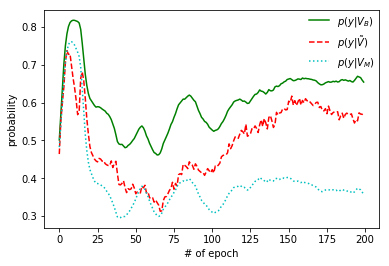

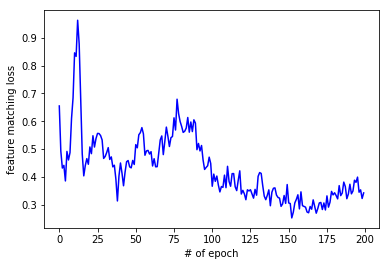

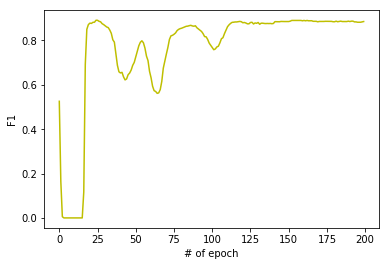

In [0]:
def draw_trend(D_real_prob, D_fake_prob, D_val_prob, fm_loss, f1):

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(311)
    p1, = plt.plot(D_real_prob, "-g")
    p2, = plt.plot(D_fake_prob, "--r")
    p3, = plt.plot(D_val_prob, ":c")
    plt.xlabel("# of epoch")
    plt.ylabel("probability")
    leg = plt.legend([p1, p2, p3], [r'$p(y|V_B)$', r'$p(y|\~{V})$', r'$p(y|V_M)$'], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)
    leg.draw_frame(False)
    # plt.legend(frameon=False)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(312)
    p4, = plt.plot(fm_loss, "-b")
    plt.xlabel("# of epoch")
    plt.ylabel("feature matching loss")
    # plt.legend([p4], ["d_real_prob", "d_fake_prob", "d_val_prob"], loc=1, bbox_to_anchor=(1, 1), borderaxespad=0.)

    fig = plt.figure()
    fig.patch.set_facecolor('w')
    # plt.subplot(313)
    p5, = plt.plot(f1, "-y")
    plt.xlabel("# of epoch")
    plt.ylabel("F1")
    # plt.legend([p1, p2, p3, p4, p5], ["d_real_prob", "d_fake_prob", "d_val_prob", "fm_loss","f1"], loc=1, bbox_to_anchor=(1, 3.5), borderaxespad=0.)
    plt.show()

    
draw_trend(d_ben_pro, d_fake_pro, d_val_pro, fm_loss_coll, f1_score)


This section apply the trained OCAN classifier and a simple linear logistic classifier on the random samples drew from the training set previously. The linear classifier is trained on a different split of supervised train-val set drew from the overall training set, due to the fact that OCAN was trained with one-class data only.

The results below show that for fraud case OCAN did not outperform the linear classifier significantly in-sample.

OCAN: 
              precision    recall  f1-score   support

     genuine     0.9113    0.9829    0.9457       700
       fraud     0.9621    0.8199    0.8853       372

    accuracy                         0.9263      1072
   macro avg     0.9367    0.9014    0.9155      1072
weighted avg     0.9289    0.9263    0.9248      1072

Accuracy Score:  0.9263059701492538

Linear Classifier: 
              precision    recall  f1-score   support

     genuine     0.9564    0.9965    0.9760       286
       fraud     0.9924    0.9091    0.9489       143

    accuracy                         0.9674       429
   macro avg     0.9744    0.9528    0.9625       429
weighted avg     0.9684    0.9674    0.9670       429

Accuracy Score:  0.9673659673659674


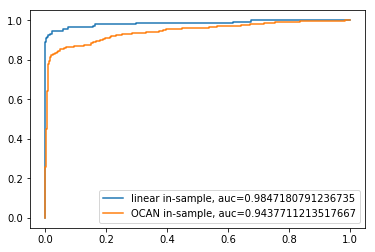

In [0]:
print ("OCAN: ")
print(conf_mat)
print ("Accuracy Score: ", accuracy_score(y_test, y_pred))

train_x, val_x, train_y, val_y = train_test_split(x_test, y_test, test_size=0.4)

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
pred_y_prob = clf.predict_proba(val_x)[:,1]

print ("")
print ("Linear Classifier: ")
print (classification_report(val_y, pred_y, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))

fpr, tpr, thresh = roc_curve(val_y, pred_y_prob)
auc = roc_auc_score(val_y, pred_y_prob)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob)
auc2 = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.plot(fpr2,tpr2,label="OCAN in-sample, auc="+str(auc2))
plt.legend(loc='best')
plt.show()

Evaluate the two classifier on the previously reserved test set, the conclusion holds if we look at the ROC curve: OCAN did not outperform linear classifier significantly.

OCAN: 
              precision    recall  f1-score   support

     genuine     0.9998    0.9772    0.9884     71082
       fraud     0.0604    0.8667    0.1129       120

    accuracy                         0.9770     71202
   macro avg     0.5301    0.9219    0.5506     71202
weighted avg     0.9982    0.9770    0.9869     71202

Accuracy Score:  0.9770371618774754

Linear Classifier: 
              precision    recall  f1-score   support

     genuine     0.9998    0.9942    0.9970     71082
       fraud     0.2012    0.8583    0.3259       120

    accuracy                         0.9940     71202
   macro avg     0.6005    0.9263    0.6615     71202
weighted avg     0.9984    0.9940    0.9959     71202

Accuracy Score:  0.9940170219937642


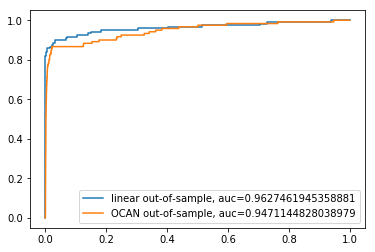

In [0]:
test_hid_rep = hidden_representation.predict(data_test.drop(['Class'], axis = 1).values)
test_y = data_test["Class"].values

prob_test, _ = sess.run([D_prob_real, D_logit_real], feed_dict={X_oc: test_hid_rep})
y_pred_test = np.argmax(prob_test, axis=1)
y_pred_prob_test = prob_test[:,1]

conf_mat_test = classification_report(test_y, y_pred_test, target_names=['genuine', 'fraud'], digits=4)
print ("OCAN: ")
print(conf_mat_test)
print ("Accuracy Score: ", accuracy_score(test_y, y_pred_test))

pred_y_test = clf.predict(test_hid_rep)
pred_y_prob_test = clf.predict_proba(test_hid_rep)[:,1]

print ("")
print ("Linear Classifier: ")
print (classification_report(test_y, pred_y_test, target_names=['genuine', 'fraud'], digits=4))
print ("Accuracy Score: ", accuracy_score(test_y, pred_y_test))

fpr, tpr, thresh = roc_curve(test_y, pred_y_prob_test)
auc = roc_auc_score(test_y, pred_y_prob_test)
fpr2, tpr2, thresh2 = roc_curve(test_y, y_pred_prob_test)
auc2 = roc_auc_score(test_y, y_pred_prob_test)
plt.plot(fpr,tpr,label="linear out-of-sample, auc="+str(auc))
plt.plot(fpr2,tpr2,label="OCAN out-of-sample, auc="+str(auc2))
plt.legend(loc='best')
plt.show()